In [65]:
import math
import nltk
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d

analyser = SentimentIntensityAnalyzer()
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jexia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [66]:
# train = pd.read_csv('/Users/mtjen/Desktop/313/project/train.csv')
train = pd.read_csv('train.csv')
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Not disaster: 57.03402075397347%
Is disaster: 42.96597924602653%


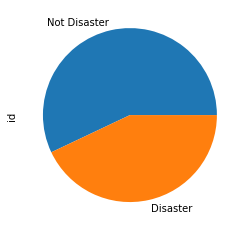

In [67]:
# Data Exploration
targets = train.groupby('target').count()['id']
ratio = targets/(targets.sum())
targets.plot(kind='pie', labels=['Not Disaster', 'Disaster'])
print(f"Not disaster: {ratio[0]*100}%")
print(f"Is disaster: {ratio[1]*100}%")
# So, we don't have to worry about data imbalance

In [68]:
# Check for missing and duplicate data
print("MISSING:")
print(train.isnull().sum())

print("\nDUPLICATE:")
print(train.duplicated().sum())

MISSING:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

DUPLICATE:
0


In [69]:
# clean tweets    
def clean(text):
    # remove non-printable characters
    cleaned = ''.join([word for word in text if word.isprintable()])
    
    # remove character references
    cleaned = re.sub(r'&[a-zA-Z]+;?', '', cleaned)
    
    return cleaned


train['text'] = train['text'].apply(clean)


cleanedTweets = []

for index in range(len(train)):
    tweet = train['text'][index]
    cleaned = re.sub(r'[^\w\s]', '', str(tweet).lower().strip())
    cleanedTweets.append(cleaned)
    
train['cleanedTweets'] = cleanedTweets

# textblob sentiment
train["sentimentText"] = train['cleanedTweets'].apply(lambda x: 
                                                      TextBlob(x).sentiment.polarity)

# vader sentiment
train["sentimentVader"] = train['cleanedTweets'].apply(lambda x: 
                                                       analyser.polarity_scores(x)['compound'])

# move target to end
col = train.pop('target')
train.insert(len(train.columns), 'target', col)

train

,id,keyword,location,text,cleanedTweets,sentimentText,sentimentVader,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,our deeds are the reason of this earthquake ma...,0.000000,0.2732,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,0.100000,-0.3400,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,-0.018750,-0.2960,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,0.000000,0.0000,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,just got sent this photo from ruby alaska as s...,0.000000,0.0000,1
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...,0.000000,-0.4939,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,aria_ahrary thetawniest the out of control wil...,0.150000,-0.5849,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,m194 0104 utc5km s of volcano hawaii httptcozd...,0.000000,0.0000,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,police investigating after an ebike collided w...,-0.260417,-0.7845,1


In [70]:
print(train[['text', 'cleanedTweets']])

                                                   text  \
0     Our Deeds are the Reason of this #earthquake M...   
1                Forest fire near La Ronge Sask. Canada   
2     All residents asked to 'shelter in place' are ...   
3     13,000 people receive #wildfires evacuation or...   
4     Just got sent this photo from Ruby #Alaska as ...   
...                                                 ...   
7608  Two giant cranes holding a bridge collapse int...   
7609  @aria_ahrary @TheTawniest The out of control w...   
7610  M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...   
7611  Police investigating after an e-bike collided ...   
7612  The Latest: More Homes Razed by Northern Calif...   

                                          cleanedTweets  
0     our deeds are the reason of this earthquake ma...  
1                 forest fire near la ronge sask canada  
2     all residents asked to shelter in place are be...  
3     13000 people receive wildfires evacuation orde...  
4

In [71]:
##### added proper noun

charsToCheck = {'!', '@', '#', '?', '.', ',', 'http'}
vowels = {'a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U'}
nouns = {'NN', 'NNS', 'NNP', 'NNPS'}
verbs = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
adj = {'JJ', 'JJR', 'JJS'}
adv = {'RR', 'RBR', 'RBS'}

hasLocation = []
hasKeyword = []
tweetNumberOfChars = []
specialCharacters = []
numberOfWords = []
avgCharsPerWord = []
numNumericTweet = []
numLettersTweet = []
numUpperTweet = []
numVowelsTweet = []
numConsonantsTweet = []
numNouns = []
numVerbs = []
numPrep = []
numAdj = []
numAdv = []
charsPerSentenceTweet = []
numSentencesTweet = []
numProperNoun = []
numTo = []


for index in range(len(train)):
    ##### location
    location = 0
    if pd.isnull(train['location'][index]) == False:
            location = 1
            
    ##### keyword
    keyword = 0
    if pd.isnull(train['keyword'][index]) == False:
            keyword = 1
    
    ###### tweet
    text = train['text'][index]
    # number of characters in tweets
    numCharsTweet = len(text)
    
    # average number of characters in sentence
    sentences = text.split('.')
    charsPerSentence = []
    for sentence in sentences:
        numCharsSentence = len(sentence)
        charsPerSentence.append(numCharsSentence)
    avgCharsPerSentence = np.mean(charsPerSentence)
    
    # number of specific special characters in tweet
    specialChars = []
    for specialChar in charsToCheck:
        numSpecialChar = text.count(specialChar)
        specialChars.append(numSpecialChar)
    
    # average characters per word
    words = text.split()
    lenWords = []
    numNumeric = 0
    numLetters = 0
    numUpper = 0
    numVowels = 0
    numConsonants = 0
    
    nounNum = 0
    verbNum = 0
    prepNum = 0
    adjNum = 0
    advNum = 0
    properNounNum = 0
    toNum = 0
    
    ans = nltk.pos_tag(words)
    for pair in ans:
        wordType = pair[1]
        if (wordType == 'NNP') or (wordType == 'NNPS'):
            properNounNum += 1
        if wordType in nouns:
            nounNum += 1
        if wordType in verbs:
            verbNum += 1
        if wordType == 'IN':
            prepNum += 1
        if wordType in adj:
            adjNum += 1
        if wordType in adv:
            advNum += 1
        if (pair[0] == "to"):
            toNum +=1
    
    for word in words:
        wordLength = len(word)
        lenWords.append(wordLength)
        
        # number of letters/numbers, uppercase, vowels, consonants
        for char in word:
            if char.isnumeric():
                numNumeric += 1
            if char.isalpha():
                numLetters += 1
                if char.isupper():
                    numUpper += 1
                if char in vowels:
                    numVowels += 1
                else:
                    numConsonants += 1
        
    wordLengthAvg = np.mean(lenWords)
    
    # tweets with 1 word
    if math.isnan(wordLengthAvg):
        wordLengthAvg = 1
    
    # number of words and sentences
    numWords = len(words)
    numSentences = len(sentences)
    
    hasLocation.append(location)
    hasKeyword.append(keyword)
    tweetNumberOfChars.append(numCharsTweet)
    specialCharacters.append(specialChars)
    numberOfWords.append(numWords)
    avgCharsPerWord.append(wordLengthAvg)
    numNumericTweet.append(numNumeric)
    numLettersTweet.append(numLetters)
    numUpperTweet.append(numUpper)
    numVowelsTweet.append(numVowels)
    numConsonantsTweet.append(numConsonants)
    numNouns.append(nounNum)
    numVerbs.append(verbNum)
    numPrep.append(prepNum)
    numAdj.append(adjNum)
    numAdv.append(advNum)
    charsPerSentenceTweet.append(avgCharsPerSentence)
    numSentencesTweet.append(numSentences)
    numProperNoun.append(properNounNum)
    numTo.append(toNum)
    
# specials
numEx = []
numAt = []
numHash = []
numQ = []
numPeriod = []
numComma = []
numLinks = []
numPunc = []

for tweetCharacters in specialCharacters:
    totalPunc = 0
    for index in range(len(charsToCheck)):
        value = tweetCharacters[index]
        totalPunc += value
        if index == 0:
            numEx.append(value)
        elif index == 1:
            numAt.append(value)
        elif index == 2:
            numHash.append(value)
        elif index == 3:
            numQ.append(value)
        elif index == 4:
            numPeriod.append(value)
        elif index == 5:
            numComma.append(value)
        elif index == 6:
            numLinks.append(value)
    numPunc.append(totalPunc)

In [72]:
##### TTR and Entropy
import string

# Clean the text further for TTR and entropy
def clean(text):
    # make all text lowercase
    cleaned = text.casefold()
    # remove non-printable characters
    cleaned = ''.join([word for word in cleaned if word in string.printable])
    # remove character references
    cleaned = re.sub(r'&[a-zA-Z]+;?', '', cleaned)
    # remove URL
    cleaned = re.sub(r'((?:https?|ftp|file)://[-\w\d+=&@#/%?~|!:;\.,]*)', '', cleaned)
    # remove HTML tags
    cleaned = re.sub(r'((?:https?|ftp|file)://[-\w\d+=&@#/%?~|!:;\.,]*)', '', cleaned)
    # remove mixtures of text and numeric
    cleaned = re.sub(r'\w*\d+\w*', '', cleaned)

    return cleaned

train['cleanedTweets'] = train['cleanedTweets'].apply(clean)
print('done cleaning')

# Vectorize contents of all tweets
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
tfidf_wm = tfidfvectorizer.fit_transform(train['cleanedTweets'])

#retrieve the terms found in the corpora
tfidf_tokens = tfidfvectorizer.get_feature_names()

# Get TFIDF representation of tweets
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = list(train.index.values) ,columns = tfidf_tokens)
print("tfidf done")

done cleaning
tfidf done


C:\Users\jexia\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [73]:
uniqueWords = []
for index in range(len(train)):
    text = train['cleanedTweets'][index]
    words = text.split()
    unique = len(set(words))
    uniqueWords.append(unique)
        
# ttr = uniqueWords/numberOfWords
ttr = []
for i in range(len(uniqueWords)):
    ttr.append(uniqueWords[i]/numberOfWords[i])
ttr

[1.0,
 1.0,
 0.8181818181818182,
 0.875,
 0.9375,
 0.8333333333333334,
 1.0,
 0.9333333333333333,
 0.9166666666666666,
 1.0,
 1.0,
 0.7037037037037037,
 0.8333333333333334,
 0.8571428571428571,
 0.9090909090909091,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.75,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.5,
 1.0,
 1.0,
 0.8,
 0.9,
 0.8888888888888888,
 1.0,
 0.9230769230769231,
 1.0,
 0.75,
 0.8421052631578947,
 1.0,
 0.625,
 0.9,
 0.9166666666666666,
 0.8333333333333334,
 0.8571428571428571,
 0.875,
 0.9230769230769231,
 0.9,
 0.625,
 0.9259259259259259,
 0.8888888888888888,
 0.9,
 0.7222222222222222,
 0.9,
 0.8666666666666667,
 0.8947368421052632,
 0.7692307692307693,
 0.7727272727272727,
 1.0,
 0.875,
 0.9411764705882353,
 0.9411764705882353,
 0.5714285714285714,
 0.8695652173913043,
 0.7777777777777778,
 1.0,
 0.9473684210526315,
 0.8846153846153846,
 0.75,
 0.9375,
 0.8823529411764706,
 0.8571428571428571,
 0.8888888888888888,
 1.0,
 0.7333333333333333,
 0.9166666666666666,
 0.888888888888

In [74]:
# Entropy
entropy = df_tfidfvect.sum(axis = 1).tolist()
print(entropy)


[2.2151132413954806, 2.4061139784849184, 2.8370939071107166, 2.393268732250653, 3.0818886077688723, 3.1227337928787837, 3.423764891271447, 1.667765367925099, 2.431930909769388, 2.194492281342691, 2.2208178279849013, 3.234092637201429, 2.9666903485620573, 1.7785027469414505, 2.6058317725385383, 1.405691911856945, 1.3748261500440266, 1.4056577788921638, 1.4056475626344112, 1.0, 1.0, 1.4127275864188622, 1.3680110417898255, 1.3836372984781278, 1.0, 1.7055383360279646, 1.4098817780327053, 1.3861450040642396, 1.0, 1.3299546969864777, 1.0, 1.9856247744667335, 2.2231744285920105, 2.6081719833278028, 1.7238021596416526, 2.2201161046605766, 3.410791099065896, 2.2106023204136838, 3.5496224726370516, 1.4138073375953646, 1.7108675802487938, 2.362664209344019, 3.6875059942156847, 1.983007813496714, 2.4254535832005777, 2.4204374945545544, 2.435389484779954, 2.6141830599126585, 1.7108675802487938, 2.923974110076987, 2.6023974542424027, 2.4152878207814266, 2.952675595574005, 2.771355017358867, 2.977440

In [75]:
# create new dataframe
colNames = ['hasLocation', 'hasKeyword', 'tweetNumberOfChars', 'numberOfWords', 'numEx', 
            'numAt', 'numHash', 'numQ', 'numPeriod', 'numComma', 'numLinks', 'numPunc',
            'avgCharsPerWord', 'numNumericTweet', 'numLettersTweet', 'numUpperTweet',
            'numVowelsTweet', 'numConsonantsTweet', 'numNouns', 'numVerbs', 'numPrep', 
            'numAdj', 'numAdv', 'charsPerSentenceTweet', 'numSentencesTweet', 'numProperNoun',
            'numTo', 'ttr', 'entropy']
colValues = [hasLocation, hasKeyword, tweetNumberOfChars, numberOfWords, numEx, numAt, 
             numHash,numQ, numPeriod, numComma, numLinks, numPunc, avgCharsPerWord, 
             numNumericTweet, numLettersTweet, numUpperTweet, numVowelsTweet, 
             numConsonantsTweet, numNouns, numVerbs, numPrep, numAdj, numAdv, 
             charsPerSentenceTweet, numSentencesTweet, numProperNoun, numTo, ttr, entropy]

# create new dataframe
data = pd.DataFrame()
for index in range(len(colNames)):
    colName = colNames[index]
    colVals = colValues[index]
    data[colName] = colVals


    
hashPerSentence = []
wordsPerSentence = []
atPerSentence = []
commasPerSentence = []
linksPerSentence = []

for index in range(len(data)):
    numSentences = data['numSentencesTweet'][index]
    numHash = data['numHash'][index]
    numWords = data['numberOfWords'][index]
    numAt = data['numAt'][index]
    numComma = data['numComma'][index]
    numLinks = data['numLinks'][index]
    
    hashPer = numHash / numSentences
    wordsPer = numWords / numSentences
    atPer = numAt / numSentences
    commasPer = numComma / numSentences
    linksPer = numLinks / numSentences
    
    hashPerSentence.append(hashPer)
    wordsPerSentence.append(wordsPer)
    atPerSentence.append(atPer)
    commasPerSentence.append(commasPer)
    linksPerSentence.append(linksPer)
    
    
data['hashPerSentence'] = hashPerSentence
data['wordsPerSentence'] = wordsPerSentence
data['atPerSentence'] = atPerSentence
data['commasPerSentence'] = commasPerSentence
data['linksPerSentence'] = linksPerSentence

In [76]:
print(data.columns)

Index(['hasLocation', 'hasKeyword', 'tweetNumberOfChars', 'numberOfWords',
       'numEx', 'numAt', 'numHash', 'numQ', 'numPeriod', 'numComma',
       'numLinks', 'numPunc', 'avgCharsPerWord', 'numNumericTweet',
       'numLettersTweet', 'numUpperTweet', 'numVowelsTweet',
       'numConsonantsTweet', 'numNouns', 'numVerbs', 'numPrep', 'numAdj',
       'numAdv', 'charsPerSentenceTweet', 'numSentencesTweet', 'numProperNoun',
       'numTo', 'ttr', 'entropy', 'hashPerSentence', 'wordsPerSentence',
       'atPerSentence', 'commasPerSentence', 'linksPerSentence'],
      dtype='object')


In [77]:
data['sentimentText'] = train['sentimentText']
data['sentimentVader'] = train['sentimentVader']
data['target'] = train['target']

# save some stuff to csv for quick reaccess
data.to_csv('features.csv')

data

,hasLocation,hasKeyword,tweetNumberOfChars,numberOfWords,numEx,numAt,numHash,numQ,numPeriod,numComma,...,ttr,entropy,hashPerSentence,wordsPerSentence,atPerSentence,commasPerSentence,linksPerSentence,sentimentText,sentimentVader,target
0,0,0,69,13,0,0,0,1,0,0,...,1.000000,2.215113,0.00,13.000000,0.0,0.00,0.000000,0.000000,0.2732,1
1,0,0,38,7,1,0,0,0,0,0,...,1.000000,2.406114,0.00,3.500000,0.0,0.00,0.000000,0.100000,-0.3400,1
2,0,0,133,22,1,0,0,0,0,0,...,0.818182,2.837094,0.00,11.000000,0.0,0.00,0.000000,-0.018750,-0.2960,1
3,0,0,65,8,0,0,0,1,1,0,...,0.875000,2.393269,0.00,8.000000,0.0,0.00,0.000000,0.000000,0.0000,1
4,0,0,88,16,0,0,0,2,0,0,...,0.937500,3.081889,0.00,16.000000,0.0,0.00,0.000000,0.000000,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,83,11,1,0,0,0,0,1,...,0.909091,2.634344,0.00,5.500000,0.0,0.50,0.000000,0.000000,-0.4939,1
7609,0,0,125,20,2,0,0,0,0,0,...,0.800000,2.933941,0.00,6.666667,0.0,0.00,0.666667,0.150000,-0.5849,1
7610,0,0,65,8,3,0,1,0,0,1,...,0.500000,1.410888,0.25,2.000000,0.0,0.25,0.000000,0.000000,0.0000,1
7611,0,0,137,19,2,0,0,0,0,0,...,0.947368,3.220383,0.00,6.333333,0.0,0.00,0.000000,-0.260417,-0.7845,1


In [78]:
# data = pd.read_csv('features.csv')


In [79]:
corr = data.corr()
top10 = abs(corr.loc['target']).sort_values(ascending=False)[1:16]
print(top10)
top10 = list(top10.index.values)

sentimentVader        0.232405
numComma              0.195455
numConsonantsTweet    0.190908
tweetNumberOfChars    0.184401
commasPerSentence     0.183376
numLettersTweet       0.182460
numNouns              0.175625
numNumericTweet       0.172301
numEx                 0.156265
numSentencesTweet     0.156265
numPrep               0.155628
numVowelsTweet        0.151178
avgCharsPerWord       0.137535
entropy               0.129417
wordsPerSentence      0.117802
Name: target, dtype: float64


<AxesSubplot:>

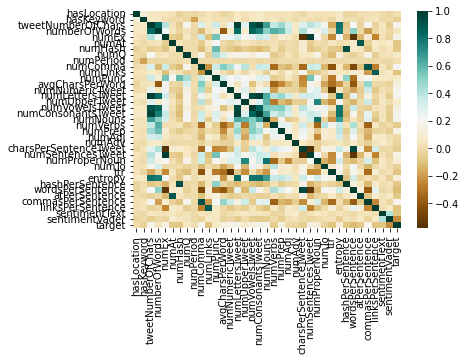

In [80]:
# Make heatmap to visualize
import seaborn as sns
sns.heatmap(corr, cmap='BrBG', yticklabels=True, xticklabels=True)

In [49]:
data_for_model = data
data_for_model

,hasLocation,hasKeyword,tweetNumberOfChars,numberOfWords,numEx,numAt,numHash,numQ,numPeriod,numComma,...,ttr,entropy,hashPerSentence,wordsPerSentence,atPerSentence,commasPerSentence,linksPerSentence,sentimentText,sentimentVader,target
0,0,0,69,13,0,0,0,1,0,0,...,1.000000,2.215113,0.00,13.000000,0.0,0.00,0.000000,0.000000,0.2732,1
1,0,0,38,7,1,0,0,0,0,0,...,1.000000,2.406114,0.00,3.500000,0.0,0.00,0.000000,0.100000,-0.3400,1
2,0,0,133,22,1,0,0,0,0,0,...,0.818182,2.837094,0.00,11.000000,0.0,0.00,0.000000,-0.018750,-0.2960,1
3,0,0,65,8,0,0,0,1,1,0,...,0.875000,2.393269,0.00,8.000000,0.0,0.00,0.000000,0.000000,0.0000,1
4,0,0,88,16,0,0,0,2,0,0,...,0.937500,3.081889,0.00,16.000000,0.0,0.00,0.000000,0.000000,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,83,11,1,0,0,0,0,1,...,0.909091,2.634344,0.00,5.500000,0.0,0.50,0.000000,0.000000,-0.4939,1
7609,0,0,125,20,2,0,0,0,0,0,...,0.800000,2.933941,0.00,6.666667,0.0,0.00,0.666667,0.150000,-0.5849,1
7610,0,0,65,8,3,0,1,0,0,1,...,0.500000,1.410888,0.25,2.000000,0.0,0.25,0.000000,0.000000,0.0000,1
7611,0,0,137,19,2,0,0,0,0,0,...,0.947368,3.220383,0.00,6.333333,0.0,0.00,0.000000,-0.260417,-0.7845,1


In [50]:
# split to train and test data
trainData = data_for_model.sample(frac = 0.8, random_state = 25)
testData = data_for_model.drop(trainData.index)

stopIndex = data_for_model.shape[1] - 1

trainArray = trainData.values
trainX = trainArray[:,0:stopIndex]
trainY = trainArray[:,stopIndex]

testArray = testData.values
testX = testArray[:,0:stopIndex]
testY = testArray[:,stopIndex]

train accuracy: 0.9975369458128078 
 test accuracy: 0.7340774786605384
Classification Report
              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79       875
         1.0       0.75      0.57      0.64       648

    accuracy                           0.73      1523
   macro avg       0.74      0.71      0.72      1523
weighted avg       0.74      0.73      0.73      1523


Confusion Matrix


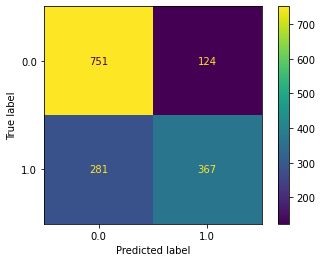

In [51]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get features and labels
X = data_for_model.drop(['target'], axis=1)
y = data_for_model['target']

# Create prelim RFC
model = RandomForestClassifier()
model.fit(trainX, trainY)
pred = model.predict(testX)

# Print train and test accuracy
print("train accuracy:",model.score(trainX, trainY),"\n","test accuracy:",model.score(testX,testY))

# Classification report and confusion matrix
print("Classification Report")
print(classification_report(testY, pred))
print("\nConfusion Matrix")
ConfusionMatrixDisplay.from_estimator(model, testX, testY)

In [35]:
# Show cross-validation for basic model
cv_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print(cv_scores)

print(cv_scores.mean())

[0.68897638 0.71784777 0.64698163 0.66622865 0.6977661  0.66754271
 0.69382392 0.64914586 0.75952694 0.68988173]
0.6877721674409621


In [52]:
# Randomly fit different hyperparameters to find optimal

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features at every split
max_features = ['none', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)
# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }
# Random search of parameters
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
model_random.fit(trainX, trainY)
# print results
print(model_random.best_params_)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\jexia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
69 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
69 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jexia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jexia\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "C:\Users\jexia\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\jexia\anaconda3\lib\site-packages\j

{'n_estimators': 1400, 'max_features': 'sqrt', 'max_depth': 260}


train accuracy: 0.9975369458128078 
 test accuracy: 0.7399868680236376
Classification Report
              precision    recall  f1-score   support

         0.0       0.73      0.86      0.79       875
         1.0       0.75      0.58      0.65       648

    accuracy                           0.74      1523
   macro avg       0.74      0.72      0.72      1523
weighted avg       0.74      0.74      0.73      1523


Confusion Matrix


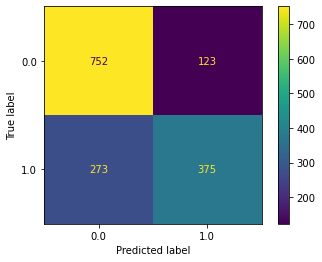

In [54]:
# New model with better parameters
model = RandomForestClassifier(n_estimators=1400, max_depth=260, max_features='sqrt')
model.fit(trainX, trainY)
pred = model.predict(testX)

# Print train and test accuracy
print("train accuracy:",model.score(trainX, trainY),"\n","test accuracy:",model.score(testX,testY))

# Classification report and confusion matrix
print("Classification Report")
print(classification_report(testY, pred))
print("\nConfusion Matrix")
ConfusionMatrixDisplay.from_estimator(model, testX, testY)

In [90]:
featureNames = data.columns.tolist()
featureNames[:-1]

['hasLocation',
 'hasKeyword',
 'tweetNumberOfChars',
 'numberOfWords',
 'numEx',
 'numAt',
 'numHash',
 'numQ',
 'numPeriod',
 'numComma',
 'numLinks',
 'numPunc',
 'avgCharsPerWord',
 'numNumericTweet',
 'numLettersTweet',
 'numUpperTweet',
 'numVowelsTweet',
 'numConsonantsTweet',
 'numNouns',
 'numVerbs',
 'numPrep',
 'numAdj',
 'numAdv',
 'charsPerSentenceTweet',
 'numSentencesTweet',
 'numProperNoun',
 'numTo',
 'ttr',
 'entropy',
 'hashPerSentence',
 'wordsPerSentence',
 'atPerSentence',
 'commasPerSentence',
 'linksPerSentence',
 'sentimentText',
 'sentimentVader']

In [93]:
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
tree= export_graphviz(estimator, out_file='tree.dot', 
                feature_names = featureNames[:-1],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

from IPython import display
display.display(tree)

None

## PREPPING KAGGLE SUBMISSION

In [60]:
# import the kaggle unlabeled data, feature extract, and predict
test = pd.read_csv('test.csv')

# clean tweets    
def clean_non_printable(text):
    cleaned = ''.join([word for word in text if word.isprintable()])
    return cleaned
def clean_char_references(text):
    cleaned = re.sub(r'&[a-zA-Z]+;?', '', text)
    return cleaned
test['text'] = test['text'].apply(clean_non_printable)
test['text'] = test['text'].apply(clean_char_references)
cleanedTweets = []
for index in range(len(test)):
    tweet = test['text'][index]
    cleaned = re.sub(r'[^\w\s]', '', str(tweet).lower().strip())
    cleanedTweets.append(cleaned)
test['cleanedTweets'] = cleanedTweets
# textblob sentiment
test["sentimentText"] = test['cleanedTweets'].apply(lambda x: 
                                                      TextBlob(x).sentiment.polarity)
# vader sentiment
test["sentimentVader"] = test['cleanedTweets'].apply(lambda x: 
                                                       analyser.polarity_scores(x)['compound'])



charsToCheck = {'!', '@', '#', '?', '.', ',', 'http'}
vowels = {'a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U'}
nouns = {'NN', 'NNS', 'NNP', 'NNPS'}
verbs = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
adj = {'JJ', 'JJR', 'JJS'}
adv = {'RR', 'RBR', 'RBS'}

hasLocation = []
hasKeyword = []
tweetNumberOfChars = []
specialCharacters = []
numberOfWords = []
avgCharsPerWord = []
numNumericTweet = []
numLettersTweet = []
numUpperTweet = []
numVowelsTweet = []
numConsonantsTweet = []
numNouns = []
numVerbs = []
numPrep = []
numAdj = []
numAdv = []
charsPerSentenceTweet = []
numSentencesTweet = []
numProperNoun = []
numTo = []


for index in range(len(test)):
    ##### location
    location = 0
    if pd.isnull(test['location'][index]) == False:
            location = 1
            
    ##### keyword
    keyword = 0
    if pd.isnull(test['keyword'][index]) == False:
            keyword = 1
    
    ###### tweet
    text = test['text'][index]
    # number of characters in tweets
    numCharsTweet = len(text)
    
    # average number of characters in sentence
    sentences = text.split('.')
    charsPerSentence = []
    for sentence in sentences:
        numCharsSentence = len(sentence)
        charsPerSentence.append(numCharsSentence)
    avgCharsPerSentence = np.mean(charsPerSentence)
    
    # number of specific special characters in tweet
    specialChars = []
    for specialChar in charsToCheck:
        numSpecialChar = text.count(specialChar)
        specialChars.append(numSpecialChar)
    
    # average characters per word
    words = text.split()
    lenWords = []
    numNumeric = 0
    numLetters = 0
    numUpper = 0
    numVowels = 0
    numConsonants = 0
    
    nounNum = 0
    verbNum = 0
    prepNum = 0
    adjNum = 0
    advNum = 0
    properNounNum = 0
    toNum = 0
    
    ans = nltk.pos_tag(words)
    for pair in ans:
        wordType = pair[1]
        if (wordType == 'NNP') or (wordType == 'NNPS'):
            properNounNum += 1
        if wordType in nouns:
            nounNum += 1
        if wordType in verbs:
            verbNum += 1
        if wordType == 'IN':
            prepNum += 1
        if wordType in adj:
            adjNum += 1
        if wordType in adv:
            advNum += 1
        if (pair[0] == "to"):
            toNum +=1
    
    for word in words:
        wordLength = len(word)
        lenWords.append(wordLength)
        
        # number of letters/numbers, uppercase, vowels, consonants
        for char in word:
            if char.isnumeric():
                numNumeric += 1
            if char.isalpha():
                numLetters += 1
                if char.isupper():
                    numUpper += 1
                if char in vowels:
                    numVowels += 1
                else:
                    numConsonants += 1
        
    wordLengthAvg = np.mean(lenWords)
    
    # tweets with 1 word
    if math.isnan(wordLengthAvg):
        wordLengthAvg = 1
    
    # number of words and sentences
    numWords = len(words)
    numSentences = len(sentences)
    
    hasLocation.append(location)
    hasKeyword.append(keyword)
    tweetNumberOfChars.append(numCharsTweet)
    specialCharacters.append(specialChars)
    numberOfWords.append(numWords)
    avgCharsPerWord.append(wordLengthAvg)
    numNumericTweet.append(numNumeric)
    numLettersTweet.append(numLetters)
    numUpperTweet.append(numUpper)
    numVowelsTweet.append(numVowels)
    numConsonantsTweet.append(numConsonants)
    numNouns.append(nounNum)
    numVerbs.append(verbNum)
    numPrep.append(prepNum)
    numAdj.append(adjNum)
    numAdv.append(advNum)
    charsPerSentenceTweet.append(avgCharsPerSentence)
    numSentencesTweet.append(numSentences)
    numProperNoun.append(properNounNum)
    numTo.append(toNum)
    
    
# specials
numEx = []
numAt = []
numHash = []
numQ = []
numPeriod = []
numComma = []
numLinks = []
numPunc = []

for tweetCharacters in specialCharacters:
    totalPunc = 0
    for index in range(len(charsToCheck)):
        value = tweetCharacters[index]
        totalPunc += value
        if index == 0:
            numEx.append(value)
        elif index == 1:
            numAt.append(value)
        elif index == 2:
            numHash.append(value)
        elif index == 3:
            numQ.append(value)
        elif index == 4:
            numPeriod.append(value)
        elif index == 5:
            numComma.append(value)
        elif index == 6:
            numLinks.append(value)
    numPunc.append(totalPunc)

    
# specials
numEx = []
numAt = []
numHash = []
numQ = []
numPeriod = []
numComma = []
numLinks = []
numPunc = []

for tweetCharacters in specialCharacters:
    totalPunc = 0
    for index in range(len(charsToCheck)):
        value = tweetCharacters[index]
        totalPunc += value
        if index == 0:
            numEx.append(value)
        elif index == 1:
            numAt.append(value)
        elif index == 2:
            numHash.append(value)
        elif index == 3:
            numQ.append(value)
        elif index == 4:
            numPeriod.append(value)
        elif index == 5:
            numComma.append(value)
        elif index == 6:
            numLinks.append(value)
    numPunc.append(totalPunc)
    
##### TTR and Entropy
import string

# Clean the text further for TTR and entropy
def clean(text):
    # make all text lowercase
    cleaned = text.casefold()
    # remove non-printable characters
    cleaned = ''.join([word for word in cleaned if word in string.printable])
    # remove character references
    cleaned = re.sub(r'&[a-zA-Z]+;?', '', cleaned)
    # remove URL
    cleaned = re.sub(r'((?:https?|ftp|file)://[-\w\d+=&@#/%?~|!:;\.,]*)', '', cleaned)
    # remove HTML tags
    cleaned = re.sub(r'((?:https?|ftp|file)://[-\w\d+=&@#/%?~|!:;\.,]*)', '', cleaned)
    # remove mixtures of text and numeric
    cleaned = re.sub(r'\w*\d+\w*', '', cleaned)

    return cleaned

test['cleanedTweets'] = test['cleanedTweets'].apply(clean)
print('done cleaning')

# Vectorize contents of all tweets
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tfidfvectorizer = TfidfVectorizer(analyzer='word',stop_words= 'english')
tfidf_wm = tfidfvectorizer.fit_transform(test['cleanedTweets'])

#retrieve the terms found in the corpora
tfidf_tokens = tfidfvectorizer.get_feature_names()

# Get TFIDF representation of tweets
df_tfidfvect = pd.DataFrame(data = tfidf_wm.toarray(),index = list(test.index.values) ,columns = tfidf_tokens)
print("tfidf done")
    
uniqueWords = []
for index in range(len(test)):
    text = test['cleanedTweets'][index]
    words = text.split()
    unique = len(set(words))
    uniqueWords.append(unique)
        
# ttr = uniqueWords/numberOfWords
ttr = []
for i in range(len(uniqueWords)):
    ttr.append(uniqueWords[i]/numberOfWords[i])
ttr
    
# Entropy
entropy = df_tfidfvect.sum(axis = 1).tolist()
print(entropy)
    
# create new dataframe
colNames = ['hasLocation', 'hasKeyword', 'tweetNumberOfChars', 'numberOfWords', 'numEx', 
            'numAt', 'numHash', 'numQ', 'numPeriod', 'numComma', 'numLinks', 'numPunc',
            'avgCharsPerWord', 'numNumericTweet', 'numLettersTweet', 'numUpperTweet',
            'numVowelsTweet', 'numConsonantsTweet', 'numNouns', 'numVerbs', 'numPrep', 
            'numAdj', 'numAdv', 'charsPerSentenceTweet', 'numSentencesTweet', 'numProperNoun', 'numTo','ttr', 'entropy']
colValues = [hasLocation, hasKeyword, tweetNumberOfChars, numberOfWords, numEx, numAt, 
             numHash,numQ, numPeriod, numComma, numLinks, numPunc, avgCharsPerWord, 
             numNumericTweet, numLettersTweet, numUpperTweet, numVowelsTweet, 
             numConsonantsTweet, numNouns, numVerbs, numPrep, numAdj, numAdv, 
             charsPerSentenceTweet, numSentencesTweet, numProperNoun, numTo, ttr, entropy]

# create new dataframe
data = pd.DataFrame()
for index in range(len(colNames)):
    colName = colNames[index]
    colVals = colValues[index]
    data[colName] = colVals


    
hashPerSentence = []
wordsPerSentence = []
atPerSentence = []
commasPerSentence = []
linksPerSentence = []

for index in range(len(data)):
    numSentences = data['numSentencesTweet'][index]
    numHash = data['numHash'][index]
    numWords = data['numberOfWords'][index]
    numAt = data['numAt'][index]
    numComma = data['numComma'][index]
    numLinks = data['numLinks'][index]
    
    hashPer = numHash / numSentences
    wordsPer = numWords / numSentences
    atPer = numAt / numSentences
    commasPer = numComma / numSentences
    linksPer = numLinks / numSentences
    
    hashPerSentence.append(hashPer)
    wordsPerSentence.append(wordsPer)
    atPerSentence.append(atPer)
    commasPerSentence.append(commasPer)
    linksPerSentence.append(linksPer)
    
    
data['hashPerSentence'] = hashPerSentence
data['wordsPerSentence'] = wordsPerSentence
data['atPerSentence'] = atPerSentence
data['commasPerSentence'] = commasPerSentence
data['linksPerSentence'] = linksPerSentence

# data['ttr'] = ttr
data['sentimentText'] = test['sentimentText']
data['sentimentVader'] = test['sentimentVader']


# save some stuff to csv for quick reaccess
# data.to_csv('features.csv')
# pd.DataFrame(ttr).to_csv('ttr.csv')

data

done cleaning
tfidf done


C:\Users\jexia\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[2.2042355087694454, 2.4400899383850225, 2.617560596218884, 1.984719746682461, 2.2281020670829608, 1.3958380331912381, 2.4625994246090905, 1.0, 1.413128353233911, 1.0, 1.6890721739181644, 1.3644369326630623, 1.4028966918185897, 0.0, 1.0, 2.796303573259092, 2.2257628385861667, 2.9819762120764173, 1.7199344138776103, 2.884806966460474, 2.4212285444158983, 2.6024106952099446, 3.423608471500522, 3.2962418428808022, 1.410367824183743, 3.6999213085011373, 2.4373606120991878, 3.959349564916077, 2.631981679265348, 2.808772410241893, 3.7952125135795343, 1.9731867727824581, 3.1351518129295677, 2.4166154151569987, 2.6102457449508325, 3.559307240279141, 2.613613974609443, 3.58350827228493, 3.0682263243435286, 2.4279785350964005, 2.96000280573982, 2.9733804315786307, 1.7056689018676483, 3.1404120798018083, 3.24592491992111, 3.306867154154901, 3.416352635498762, 3.1580758092848957, 3.141367850574827, 3.1580758092848957, 2.1092256265483114, 2.8038477194934406, 2.7750907928285615, 3.1580758092848957, 

,hasLocation,hasKeyword,tweetNumberOfChars,numberOfWords,numEx,numAt,numHash,numQ,numPeriod,numComma,...,numTo,ttr,entropy,hashPerSentence,wordsPerSentence,atPerSentence,commasPerSentence,linksPerSentence,sentimentText,sentimentVader
0,0,0,34,6,0,0,0,0,0,0,...,0,1.000000,2.204236,0.0,6.00,0.0,0.0,0.0,-1.00,-0.7003
1,0,0,64,9,1,0,0,1,1,0,...,0,1.000000,2.440090,0.0,4.50,0.0,0.0,0.0,0.25,0.4404
2,0,0,96,19,0,0,0,0,2,0,...,0,1.000000,2.617561,0.0,19.00,0.0,0.0,0.0,0.00,-0.6159
3,0,0,40,4,1,0,0,2,0,0,...,0,1.000000,1.984720,0.0,2.00,0.0,0.0,0.0,0.00,0.0000
4,0,0,45,8,0,0,0,0,0,0,...,0,0.875000,2.228102,0.0,8.00,0.0,0.0,0.0,0.00,-0.5423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0,0,54,8,0,0,0,0,0,0,...,0,0.750000,2.375435,0.0,8.00,0.0,0.0,0.0,0.00,0.6808
3259,0,0,134,23,3,0,0,0,0,0,...,0,0.869565,3.267089,0.0,5.75,0.0,0.0,0.0,-0.20,-0.1531
3260,0,0,55,6,1,0,0,0,0,1,...,0,1.000000,2.221656,0.0,3.00,0.0,0.5,0.0,-0.20,0.0000
3261,0,0,65,7,1,0,0,0,0,1,...,0,0.857143,2.436200,0.0,3.50,0.0,0.5,0.0,0.60,0.0000


In [61]:
# Create predictions on test set based on model
prediction = pd.Series(model.predict(data))


C:\Users\jexia\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [62]:
prediction = prediction.apply(np.int64)

submission = {'id': test['id'], 
             'target': prediction}

submission = pd.concat(submission, axis=1)
submission

submission.to_csv('submission.csv', index = False)